Drill Hole Compound Likelihood Demo
===================================

In [73]:
%matplotlib inline

In [74]:
import matplotlib.pyplot as pl
import numpy as np
import logging

import revrand.optimize as opt
from revrand import glm
from revrand.basis_functions import BiasBasis, RandomRBF
from revrand.btypes import Parameter, Positive
from revrand.utils.datasets import gen_gausprocess_se
from revrand.mathfun.special import softplus

from uncoverml.likelihoods import Switching, PosGaussian

# Log output to the terminal attached to this notebook
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

# Warning handling
#np.seterr(all='warn')
import warnings
warnings.filterwarnings('error')


Demo settings
-------------

In [75]:
# Dataset properties
N = 300
Ns = 250
offset = 20
lenscale_true = 1.2  # For the gpdraw dataset
noise_true = 0.1
hit_proportion = 1.0

fig_width = 15
fig_height = 10


Algorithm Settings
------------------

In [76]:
nbases = 20
lenscale = 1  # For all basis functions that take lengthscales
maxiter = 3000
batch_size = 10
use_sgd = True
regulariser = 1.
noise = 1.
#updater = opt.AdaDelta(rho=0.1, epsilon=1e-6)
updater = opt.Adam(alpha=0.01, epsilon=1e-5, beta1=0.1, beta2=0.3)


Make data
---------

In [77]:
hit = np.random.binomial(n=1, p=hit_proportion, size=N).astype(bool)
not_hit = ~ hit
Xtrain, ftrain, Xtest, ftest = \
    gen_gausprocess_se(N, Ns, lenscale=lenscale_true, noise=0.0)

gtrain = ftrain + offset
gtest = ftest + offset

ytrain = np.empty(N)
ytrain[hit] = gtrain[hit] + np.random.randn(hit.sum()) * noise_true
ytrain[not_hit] = np.random.rand(not_hit.sum()) * gtrain[not_hit]


Set up likelihood and Basis
---------------------------

In [78]:
# Make parameter types
var = Parameter(noise**2, Positive())
regulariser = Parameter(regulariser, Positive())
lenscale_init = Parameter(lenscale, Positive(10))

# Likelihood
learn_args = (hit,)
pred_args = (np.ones(Ns, dtype=bool),)
like = Switching(var_init=var)

#learn_args = ()
#pred_args = ()
#like = PosGaussian(var_init=var)

# Regression Basis
basis = BiasBasis(offset=offset) \
    + RandomRBF(nbases, Xtrain.shape[1], lenscale_init)


Learning and prediction
-----------------------

In [79]:
# Learning
params = glm.learn(Xtrain, ytrain, like, basis, regulariser=regulariser,
                   likelihood_args=learn_args, use_sgd=use_sgd,
                   batch_size=batch_size, maxiter=maxiter, updater=updater)

# Expected drill hole measurements (proxy for basement depth)
Ey, Vy, Eyn, Eyx = glm.predict_moments(Xtest, like, basis, *params,
                                       likelihood_args=pred_args)

# 95% confidence interval
y95n, y95x = glm.predict_interval(0.8, Xtest, like, basis, *params,
                                  multiproc=False,
                                  likelihood_args=pred_args)


fmin: -7.040871332507091, fmax: -2.881103495005903, fshape: (10,)
fmin: 14.399712876367843, fmax: 16.153836099465682, fshape: (10,)
fmin: 18.776348643178807, fmax: 21.35793885575737, fshape: (10,)
fmin: 18.93537429416731, fmax: 21.04448120176255, fshape: (10,)
fmin: 19.00893277741372, fmax: 21.159690415841624, fshape: (10,)
fmin: 18.99790934334885, fmax: 21.028372281911413, fshape: (10,)
fmin: 19.21852185495155, fmax: 21.13035043147487, fshape: (10,)
fmin: 19.863445191566502, fmax: 21.427009529694452, fshape: (10,)
fmin: 18.696132490322263, fmax: 21.149448350979576, fshape: (10,)
fmin: 18.32058057152763, fmax: 21.3560088780326, fshape: (10,)
fmin: 18.828764742916952, fmax: 21.568988447259194, fshape: (10,)
fmin: 19.119182122468725, fmax: 21.347573824867382, fshape: (10,)
fmin: 18.320371026149257, fmax: 21.085555389356614, fshape: (10,)
fmin: 19.04013603439086, fmax: 21.41976459183835, fshape: (10,)
fmin: 18.563030520745365, fmax: 21.70781826978684, fshape: (10,)
fmin: 18.54550175305661

Visualise
---------

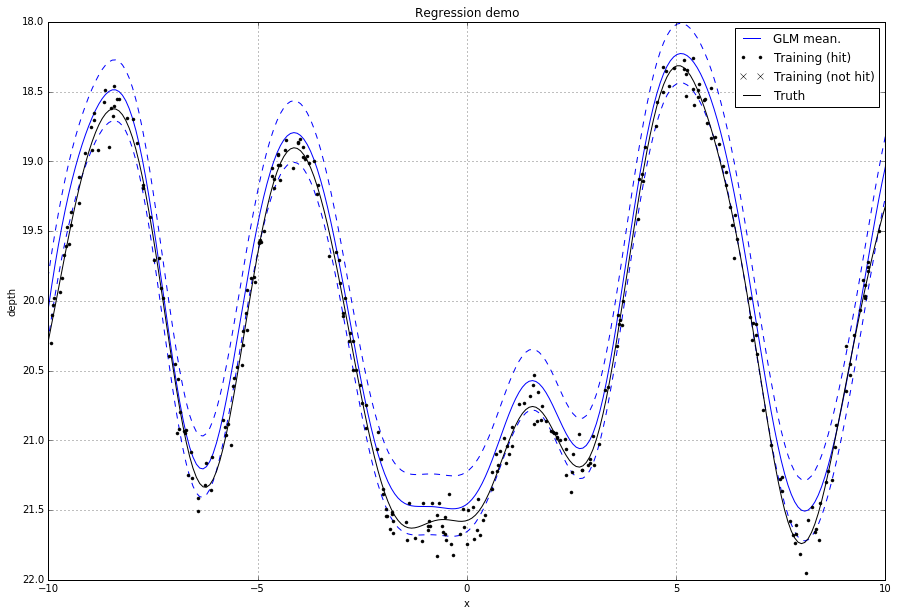

In [80]:
Xpl_t = Xtrain.flatten()
Xpl_s = Xtest.flatten()

# Regressor
pl.figure(figsize=(fig_width, fig_height))
pl.plot(Xpl_s, Ey, 'b-', label='GLM mean.')
pl.fill_between(Xpl_s, y95n, y95x, facecolor='none', edgecolor='b', label=None,
                linestyle='--')

# # Training/Truth
pl.plot(Xpl_t[hit], ytrain[hit], 'k.', label='Training (hit)')
pl.plot(Xpl_t[not_hit], ytrain[not_hit], 'kx', label='Training (not hit)')
pl.plot(Xpl_s, gtest, 'k-', label='Truth')

pl.gca().invert_yaxis()
pl.legend()
pl.grid(True)
pl.title('Regression demo')
pl.ylabel('depth')
pl.xlabel('x')

pl.show()
